In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import torch
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from scipy.interpolate import UnivariateSpline
import statsmodels.formula.api as smf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')
ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
ts_df = ts_df.loc[ts_df['count'] >= 50]

In [6]:
category_norms = pd.read_csv('./data/Referential version_Item level data.csv')
category_norms = category_norms.loc[category_norms['prod.freq'] > 1]
category_norms.groupby('category')['category.member'].count().to_dict()

{'academic subject': 41,
 'alcoholic drink': 30,
 'animal': 69,
 'art form': 16,
 'artistic movement': 9,
 'bathroom fixture': 19,
 'bird': 38,
 'bird of prey': 8,
 'boat': 16,
 'body of water': 15,
 'book genre': 22,
 'breed of dog': 36,
 'building': 34,
 'building material': 18,
 'camping equipment': 25,
 "carpenter's tool": 16,
 'chemical element': 35,
 'citrus fruit': 11,
 'clothing': 47,
 'colour': 24,
 'cosmetic': 23,
 'crime': 25,
 'dairy product': 11,
 'day of the week': 7,
 'disease': 24,
 'drug': 24,
 'emotion': 27,
 'fabric': 15,
 'family relationship': 42,
 'farm animal': 18,
 'fish': 26,
 'flower': 18,
 'four-legged animal': 38,
 'four-wheeled vehicle': 13,
 'fraction': 24,
 'fruit': 40,
 'fuel': 14,
 'furniture': 24,
 'gardening tool': 18,
 'gemstone': 12,
 'geometric shape': 17,
 'green vegetable': 19,
 'hair colour': 18,
 'hat': 17,
 'healthcare profession': 23,
 'herb': 16,
 'human dwelling': 18,
 'infectious disease': 14,
 'injury': 20,
 'insect': 27,
 'jewellery': 14

In [7]:
all_words = set(category_norms['category.member'])
small_df = ts_df.loc[ts_df.words.isin(all_words)]
norms = category_norms.groupby('category')['category.member'].apply(list).to_dict()
category_df = pd.DataFrame()
for category in norms:
    words = norms[category]
    c_df = small_df.loc[small_df.words.isin(words)]
    c_df['category'] = category
    category_df = pd.concat((category_df, c_df), ignore_index = True)
    
category_morality = {c: category_df.loc[(category_df.category == c) & (category_df.property == 'previous_link')].outputs_z.mean() for c in norms}


/tmp/ipykernel_2765345/3237992237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df['category'] = category
/tmp/ipykernel_2765345/3237992237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df['category'] = category
/tmp/ipykernel_2765345/3237992237.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

# Selecting categories


In [8]:
th_moral = 0
categories = [c for c in category_morality if category_morality[c] > th_moral]
len(categories)

25

In [9]:
th_size = 3
th_year = 10
th_intersection = 10

In [10]:
lengthy_words = category_df.loc[(category_df.property == 'previous_link')][['words','year']].drop_duplicates().groupby('words').year.count().to_dict()
lengthy_words = {w for w in lengthy_words if lengthy_words[w] >= th_year and any([w in norms[c] for c in categories])}
len(lengthy_words)


237

In [11]:
category_df = category_df.loc[(category_df.words.isin(lengthy_words)) & (category_df.property == 'previous_link')].reset_index(drop = True)

In [12]:
category_count = category_df[['category','words']].drop_duplicates().groupby('category').words.count().to_dict()
categories = {c for c in category_count if category_count[c] >= th_size
             }
categories

{'academic subject',
 'book genre',
 'building',
 'crime',
 'disease',
 'drug',
 'emotion',
 'family relationship',
 'healthcare profession',
 'infectious disease',
 'injury',
 'legal profession',
 'medical specialty',
 'military title',
 'negative emotion',
 'non-violent crime',
 'personal quality',
 'political system',
 'positive emotion',
 'positive personal quality',
 'profession',
 'religion',
 'religious building',
 'royal title',
 'science',
 'social gathering',
 'social relationship',
 'supernatural being',
 'symptom of illness',
 'tool',
 'violent crime',
 'weapon'}

In [13]:
len(categories)

32

In [14]:
df_pivot = category_df.loc[(category_df.property == 'previous_link')].\
loc[(category_df.words.isin(lengthy_words)) & (category_df.category.isin(categories))][['words','year','outputs_z']].drop_duplicates()\
.pivot(index='words', columns='year', values='outputs_z')


In [15]:
category_count = {}
word_cats = {word: set(category_df.loc[category_df.words == word].loc[category_df.category.isin(categories)].category) for word in df_pivot.index}
for word,cats in word_cats.items():
    for cat in cats:
        if cat not in category_count:
            category_count[cat] = 0
        category_count[cat] += 1  

In [16]:
cor_matrix = df_pivot.T.corr()
cor_matrix_2 = cor_matrix.copy(deep = True)

for i, word1 in enumerate(cor_matrix.index): #We will mask mask out pair words that don't intersection more than 10 years
    for j, word2 in enumerate(cor_matrix.index):
        if j >= i:
            continue
            
        word1_years = set(df_pivot.loc[word1].dropna().index)
        word2_years = set(df_pivot.loc[word2].dropna().index)
        intersection = word1_years.intersection(word2_years)
        if len(intersection) < th_intersection:
            cor_matrix[word1][word2]= None
            cor_matrix[word2][word1]= None
        

/tmp/ipykernel_2765345/1900790190.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cor_matrix[word1][word2]= None
/tmp/ipykernel_2765345/1900790190.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You ar

In [17]:
plot_cor = cor_matrix_2.dropna(axis = 0).dropna(axis = 1)

In [18]:
indices = set(cor_matrix.index)
category_count = {c: len([w for w in norms[c] if w in indices]) for c in categories}

In [19]:
import matplotlib.patches as patches


In [20]:
def get_average_c(category_words):
    all_cs = []
    category_cs = {}
    for c, c_words in category_words.items():
        matrix = cor_matrix.loc[c_words][c_words] 
        null_values = sum(pd.isnull(matrix.values).flatten())
        total = len(matrix.values) ** 2
        value_sum = np.nansum(matrix.values) - len(matrix.values)
        average_cor = (value_sum) / (total - null_values - len(matrix.values))
        all_cs.append((value_sum, (total - null_values - len(matrix.values))))
        
        category_cs[c] = average_cor
    average_c = np.nanmean(list(category_cs.values())    )         
    return average_c,category_cs, all_cs

In [21]:
row_clusters2 = [list(word_cats[w])[0] for w in cor_matrix.index]

In [22]:
categories = set(row_clusters2)

In [23]:
category_words = {c: [w for w in cor_matrix.index if w in norms[c]] for c in categories}

In [24]:
len(categories)

27

In [25]:
average_c,category_cs,all_cs = get_average_c(category_words)
total_sum = sum([x[0] for x in all_cs])
total_den = sum([x[1] for x in all_cs])
all_cs_average = total_sum / total_den

In [26]:
sort_categories = sorted(category_cs.keys(), key= lambda x : -category_cs[x])
{c: category_cs[c] for c in sort_categories}

{'non-violent crime': 0.7688069379169961,
 'family relationship': 0.590533512610035,
 'crime': 0.487516125023347,
 'social relationship': 0.2808929029090003,
 'healthcare profession': 0.26358358126050946,
 'medical specialty': 0.24814280989989737,
 'violent crime': 0.24706242952655502,
 'religion': 0.18003710884975246,
 'military title': 0.17192495066320512,
 'political system': 0.12220202034692461,
 'profession': 0.0981127886771466,
 'negative emotion': 0.08986284042052389,
 'positive personal quality': 0.0832213462712679,
 'building': 0.08044940877470097,
 'social gathering': 0.07628384836029767,
 'royal title': 0.07609470300281437,
 'supernatural being': 0.06075142917610605,
 'religious building': 0.04799593586134548,
 'academic subject': 0.02555487103003964,
 'legal profession': 0.020904745162265304,
 'drug': 0.01430822100840956,
 'emotion': 0.0017347025778499633,
 'injury': -0.010382256637733943,
 'symptom of illness': -0.015415213811270439,
 'weapon': -0.023298304447457348,
 'boo

### Sorting based on category inner correlation vs size


In [27]:
sort_categories = sorted(category_cs.keys(), key= lambda x : -category_cs[x]) #Inner correlation
saving = 'corr_sort'
top_categories = sort_categories[:20]


In [28]:
from collections import Counter
counter = Counter(row_clusters2)
for c in counter:
    if counter[c] < 3:
        top_categories.remove(c)
top_categories = top_categories[:15]
top_categories

['non-violent crime',
 'family relationship',
 'crime',
 'social relationship',
 'religion',
 'military title',
 'political system',
 'profession',
 'negative emotion',
 'positive personal quality',
 'building',
 'social gathering',
 'royal title',
 'supernatural being',
 'religious building']

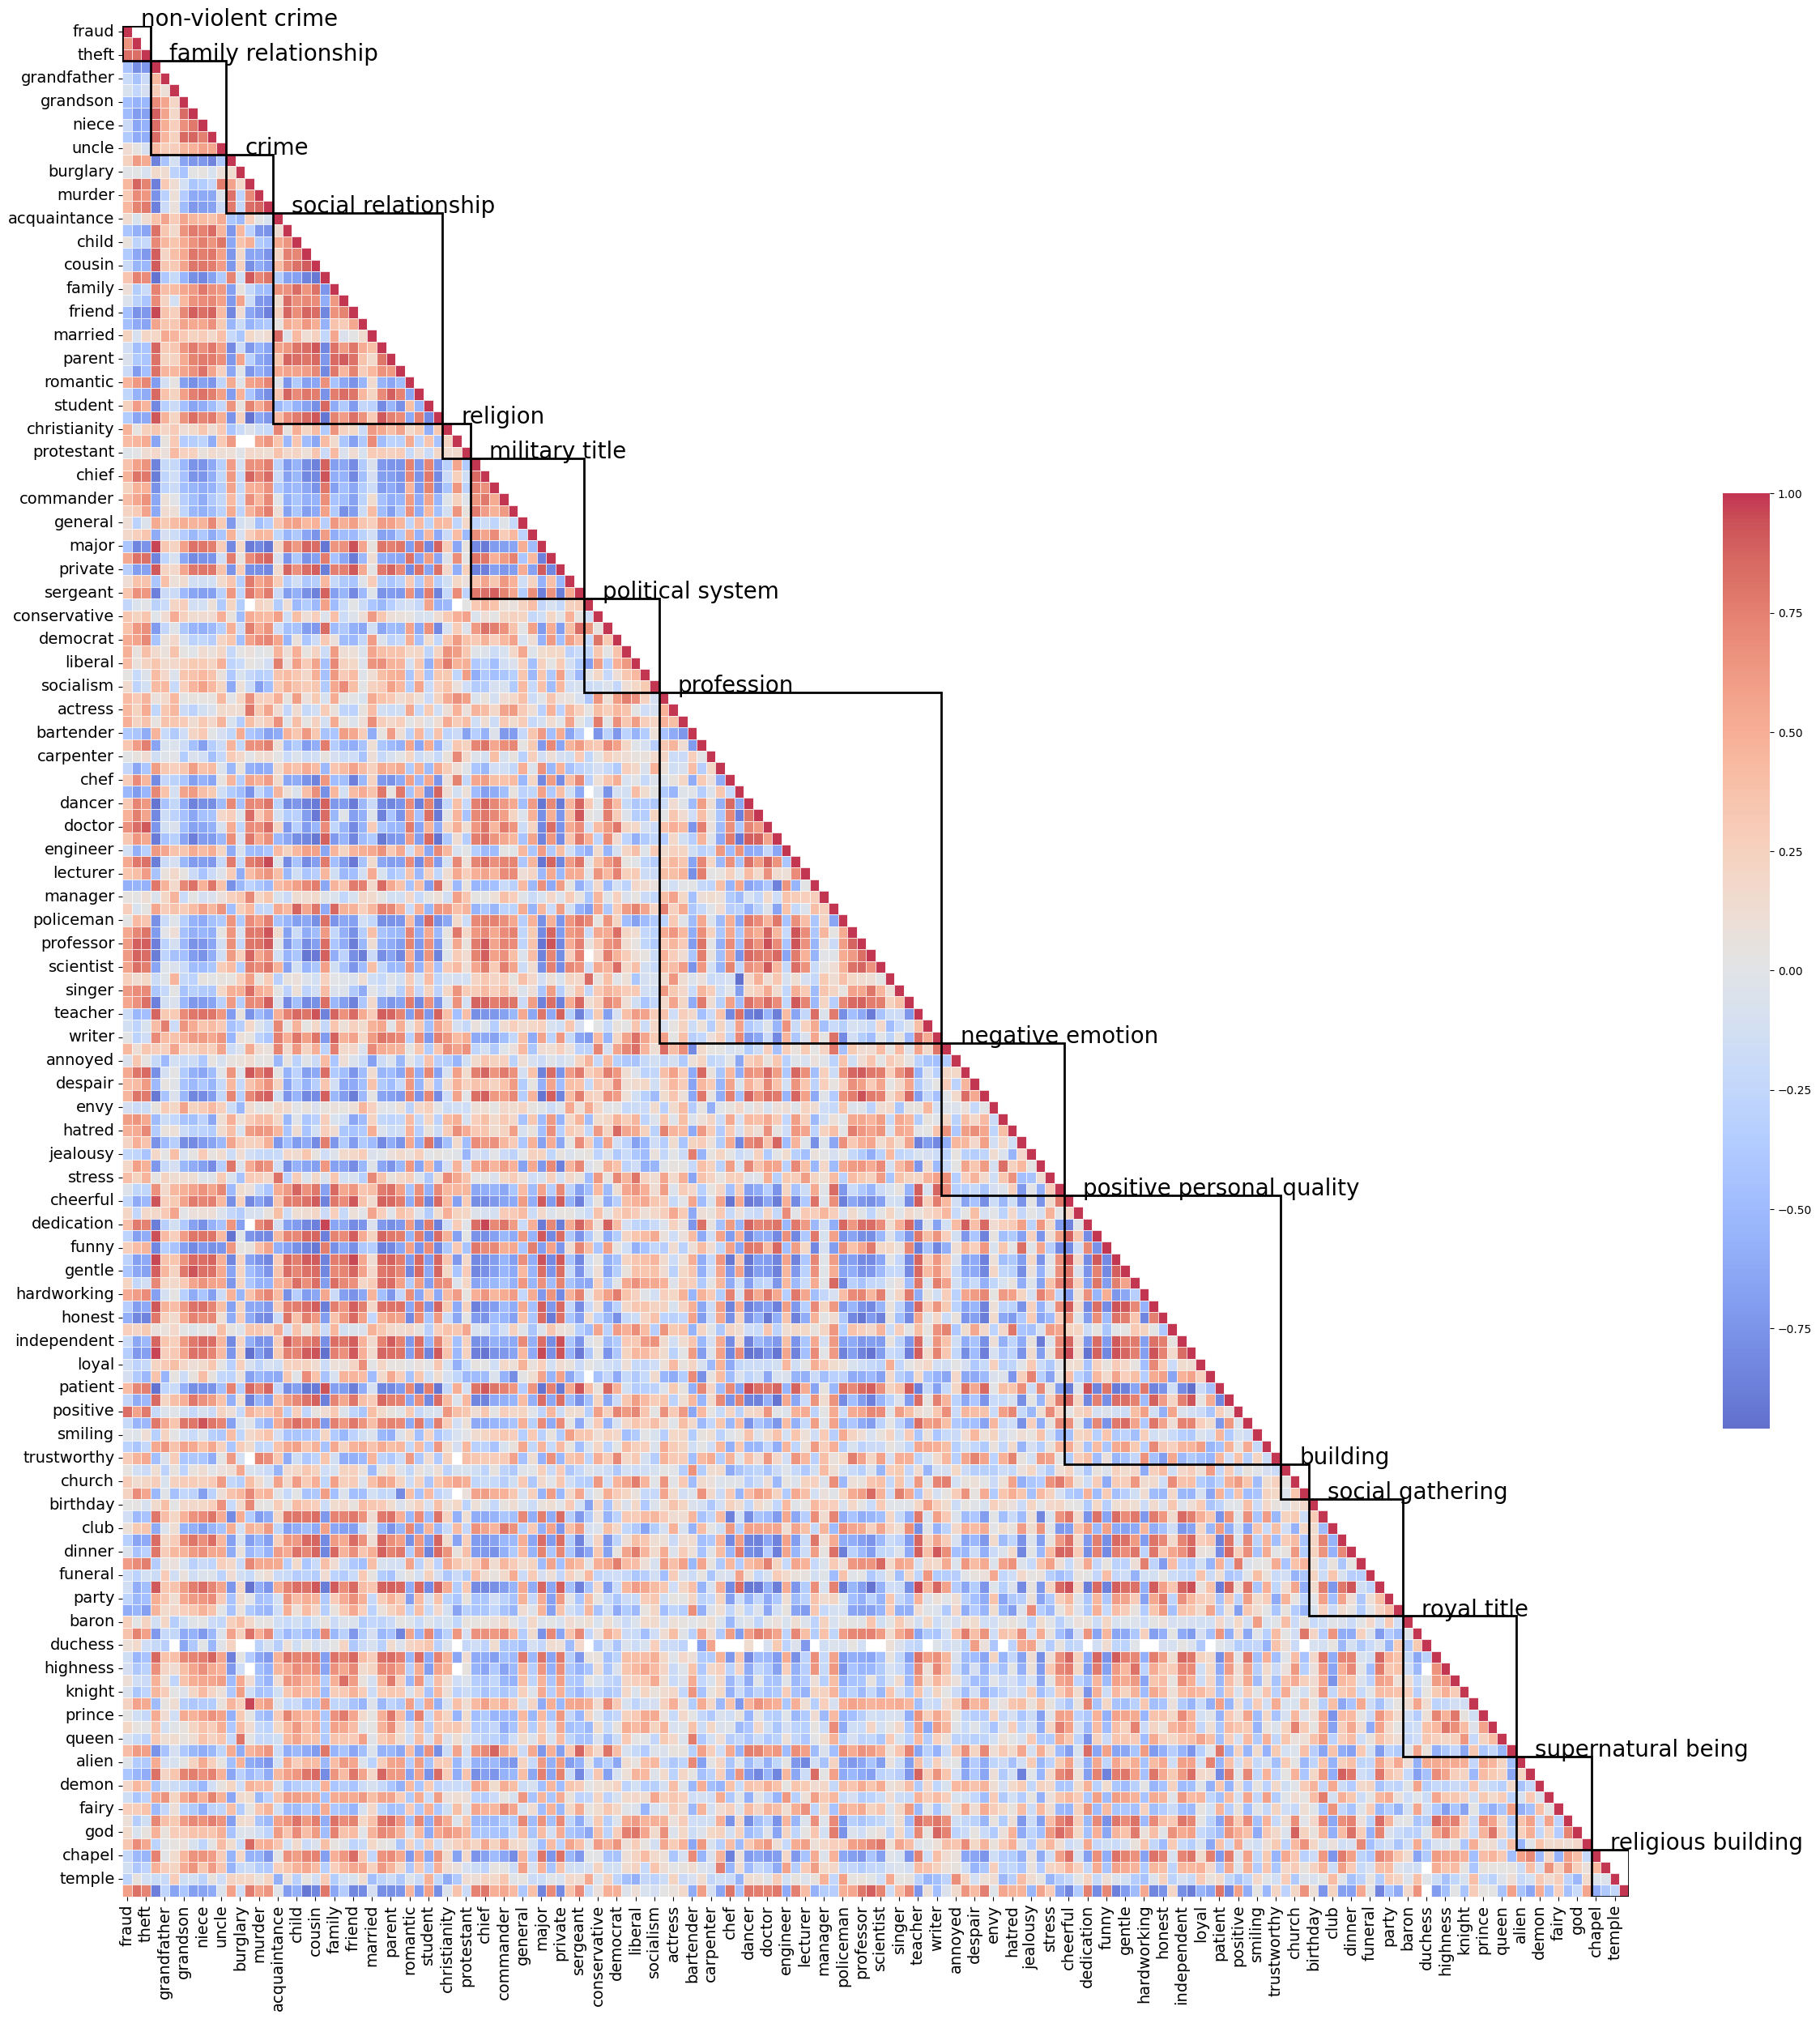

In [29]:
row_clusters2 =np.array(row_clusters2)
sorted_indices = sorted(np.arange(len(row_clusters2)), key = lambda index: -category_cs[row_clusters2[index]])
sorted_indices = [index for index in sorted_indices if row_clusters2[index] in top_categories]
sorted_corr_matrix = cor_matrix.iloc[sorted_indices, sorted_indices]
row_clusters_small = row_clusters2[sorted_indices]
plt.figure(figsize=(30, 30)) 



mask = np.triu(np.ones_like(sorted_corr_matrix, dtype=bool), k=1)

sns.heatmap(sorted_corr_matrix.rename_axis(index=None, columns=None), cmap='coolwarm', annot=False,  cbar_kws={"shrink": 0.5}, linewidths=0.5, 
               xticklabels = 2, 
               yticklabels = 2,  
            alpha = 0.8,
            mask = mask
           )

previous_group = row_clusters_small[0]

start_idx = 0
plt.text(start_idx + 2 ,
                 start_idx, previous_group, fontsize = 20)

for i, group in enumerate(row_clusters_small):
    if group != previous_group:
        rect = patches.Rectangle((start_idx, start_idx), i - start_idx, i - start_idx,
                                 linewidth=2, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rect)
        
        start_idx = i  
        plt.text(start_idx + 2 ,
                 start_idx, group, fontsize = 20)


    
    previous_group = group


rect = patches.Rectangle((start_idx, start_idx), len(row_clusters_small) - start_idx, 
                         len(row_clusters_small) - start_idx,
                      linewidth=2, edgecolor='black', facecolor='none')



plt.gca().add_patch(rect)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()


# Category pair-wise correlation

In [30]:
list_rows = []
for c1 in sort_categories:
    for c2 in sort_categories:
        total = 0
        total_cor = 0
        c1_words = category_words[c1]
        c2_words = category_words[c2]
        for w1 in c1_words:
            for w2 in c2_words:
                if w1 != w2 and not pd.isnull(cor_matrix.loc[w1][w2]):
                    total += 1
                    total_cor += cor_matrix.loc[w1][w2]
        
        list_rows.append({
            'c1':c1,
            'c2':c2,
            'correlation': total_cor / total,
            'n': total
        })
                
        

In [31]:
category_pairwise_cor = pd.DataFrame(list_rows)

In [32]:
category_pairwise_cor_pivot = category_pairwise_cor.sort_values(by = 'correlation',ascending = False).pivot(index = 'c1', columns = 'c2',values ='correlation')
category_pairwise_cor_pivot

c2,academic subject,book genre,building,crime,disease,drug,emotion,family relationship,healthcare profession,injury,...,profession,religion,religious building,royal title,social gathering,social relationship,supernatural being,symptom of illness,violent crime,weapon
c1,,,,,,,,,,,,,,,,,,,,,
academic subject,0.025555,0.077408,-0.001350,-0.100020,-0.056026,-0.045305,0.010661,0.137935,-0.047002,0.023359,...,-0.028099,0.037118,0.026048,0.073427,0.066871,0.113476,0.075717,0.052156,-0.083762,-0.036907
book genre,0.077408,-0.040614,0.100903,0.023278,-0.122826,0.028487,0.068687,0.159391,0.038989,0.065071,...,0.034358,0.168561,0.065393,0.119018,0.089406,0.167022,0.114731,0.070226,0.014212,-0.004053
building,-0.001350,0.100903,0.080449,0.255172,-0.087659,0.033440,0.147364,-0.109138,0.173400,-0.046261,...,0.084921,0.089415,0.095033,0.133603,-0.070488,-0.053967,0.056109,0.029481,0.157957,0.099224
crime,-0.100020,0.023278,0.255172,0.487516,-0.057376,0.212753,0.169401,-0.401763,0.355503,-0.098160,...,0.218458,0.164298,0.064607,0.023501,-0.168045,-0.237546,-0.059166,-0.052216,0.380267,0.124698
disease,-0.056026,-0.122826,-0.087659,-0.057376,-0.184707,-0.010896,-0.023336,-0.009131,-0.098091,-0.031859,...,-0.046129,-0.149949,-0.025894,-0.042170,-0.016968,-0.044360,-0.032376,-0.038407,-0.047258,-0.017111
drug,-0.045305,0.028487,0.033440,0.212753,-0.010896,0.014308,0.037118,-0.154419,0.102348,-0.008037,...,0.078604,0.051569,-0.035025,-0.035428,-0.053188,-0.091471,-0.064946,-0.034572,0.179642,0.028629
emotion,0.010661,0.068687,0.147364,0.169401,-0.023336,0.037118,0.001735,-0.051941,0.206292,-0.022569,...,0.079302,0.011155,0.089584,0.040542,-0.022264,-0.020792,0.044070,0.035747,0.112236,0.066938
family relationship,0.137935,0.159391,-0.109138,-0.401763,-0.009131,-0.154419,-0.051941,0.590534,-0.233117,0.163494,...,-0.107529,0.033548,0.040814,0.113195,0.285132,0.413809,0.224325,0.171318,-0.316649,-0.079445
healthcare profession,-0.047002,0.038989,0.173400,0.355503,-0.098091,0.102348,0.206292,-0.233117,0.263584,-0.068848,...,0.163288,0.156074,0.065005,0.049271,-0.096758,-0.134572,0.038841,0.038777,0.256723,0.112721


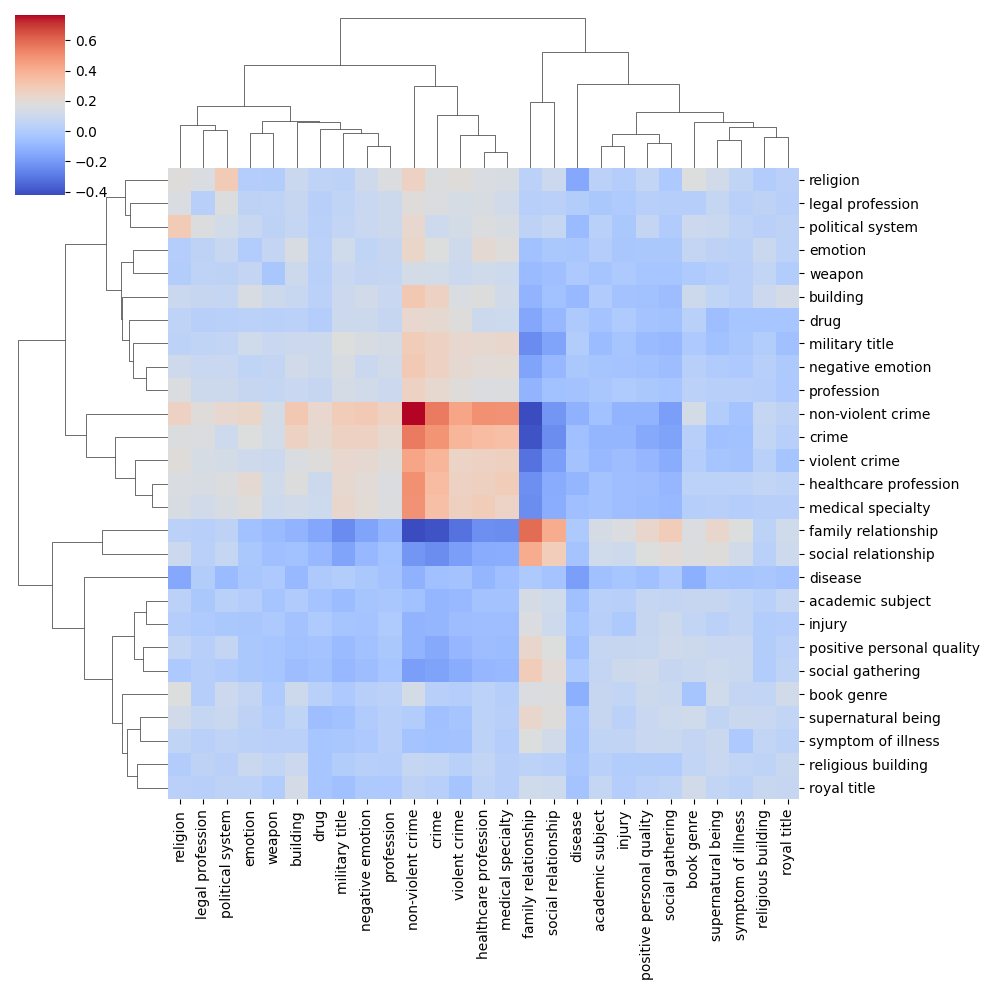

In [33]:
sns.clustermap(category_pairwise_cor_pivot.rename_axis(index=None, columns=None), cmap='coolwarm')
# plt.savefig('notebooks/figs/coha_category_pairwise.pdf', dpi = 400, bbox_inches = 'tight')

# Permutation test analysis



In [34]:
B = 1000

In [35]:
category_words = {c: list(set(c_words)) for c, c_words in category_words.items()}

In [36]:
def get_average_catgory(c_words):
    
    matrix = cor_matrix.loc[c_words][c_words] 
    null_values = sum(pd.isnull(matrix.values).flatten())
    total = len(matrix.values) ** 2
    value_sum = np.nansum(matrix.values) - len(matrix.values)
    average_cor = (value_sum) / (total - null_values - len(matrix.values))
          
    return average_cor, value_sum, (total - null_values - len(matrix.values))

In [37]:
def get_average_c(category_words):
    category_cs = {}
    for c, c_words in category_words.items():
        matrix = cor_matrix.loc[c_words][c_words] 
        null_values = sum(pd.isnull(matrix.values).flatten())
        total = len(matrix.values) ** 2
        value_sum = np.nansum(matrix.values) - len(matrix.values)
        average_cor = (value_sum) / (total - null_values - len(matrix.values))
        category_cs[c] = average_cor
    average_c = np.nanmean(list(category_cs.values())    )         
    return average_c,category_cs

In [38]:
#Starting the permutation

In [39]:
indices = list(cor_matrix.index)
sizes = {c: len(c_words) for c, c_words in category_words.items()}

In [40]:
random_average_cs = []
b_sizes = np.cumsum(list(sizes.values()))
all_cs = []
random_category_cs = {c: [] for c in category_cs}
for b in range(B):
    print(b)
    b_num_sums = 0
    b_den_sums = 0
    b_all_cs = []
    b_cs = []
    for c in categories:
        c_words = np.random.choice(indices, sizes[c])
        average_cor,value_sum, den = get_average_catgory(c_words) 
        random_category_cs[c].append(average_cor)
        b_cs.append(  random_category_cs[c][-1])
        b_num_sums +=  value_sum
        b_den_sums += den
    
    b_cs = np.nanmean(b_cs)
    random_average_cs.append(b_cs)
    all_cs.append(b_num_sums / b_den_sums)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
sum([all_cs_average <  x for x in all_cs]) / B

0.0

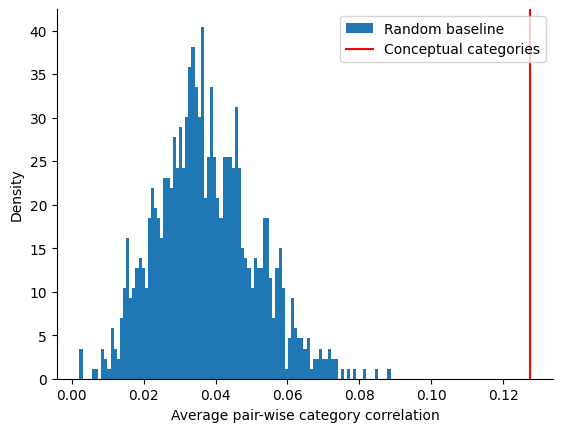

In [42]:
plt.hist(all_cs,label = 'Random baseline',density = True, bins = 100)
plt.axvline(x = all_cs_average,label = 'Conceptual categories',color = 'red')
plt.xlabel('Average pair-wise category correlation')
plt.ylabel('Density')
plt.legend()
# plt.savefig('notebooks/figs/coha_all_pairwise_correlation_permutation.pdf', dpi= 300, bbox_inches = 'tight')
sns.despine()